# Simple skill assessment for HydroTas 2020-2021 workplan:
- rainfall, surface temp and surface wind over Australia region and Tasmania region
- Assess skill as function of start month and ensemble size

In [1]:
import sys
sys.path.insert(0, '/OSM/CBR/OA_DCFP/work/squ027/software/xskillscore')

import cmocean
import matplotlib
import numpy as np
import xarray as xr
import myfuncs as my
import xskillscore as xs
from matplotlib import cm
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

import warnings
warnings.filterwarnings("ignore")

# Cluster for bootsrapping

In [2]:
cluster = SLURMCluster(
    walltime='02:00:00', 
    cores=6, 
    memory='36GB', 
    job_extra=['--qos="express"'])

In [3]:
cluster.scale(jobs=6)
client = Client(cluster)
client

Client Scheduler: tcp://10.141.1.194:42437 Dashboard: http://10.141.1.194:42085/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Parameters

In [4]:
CLIM_PERIOD = slice('1990-01-01', '2019-12-31') # For defining climatological probabilities
TEST_PERIOD = slice('1990-01-01', '2019-12-31')

ROLLING_LEAD_AVERAGES = [3, 6, 12, 24, 36, 60] # For jelly plots
REGIONS = ['AUS', 'MEL', 'TAS']

CMAP = matplotlib.colors.ListedColormap(
    cm.get_cmap(cmocean.cm.curl_r)(np.linspace(0, 1, 21)))

PARAMS = [{'obsv_file': 'data/awap_precip_{region}_anom.zarr',
           'fcst_file': 'data/f6_precip_{region}_anom.zarr'},
          
          {'obsv_file': 'data/jra55_t_ref_{region}_anom.zarr',
           'fcst_file': 'data/f6_t_ref_{region}_anom.zarr'},
          
          {'obsv_file': 'data/jra55_V_ref_{region}_anom.zarr',
           'fcst_file': 'data/f6_V_ref_{region}_anom.zarr'}]

N_BOOTSTRAPS = 1000

# Perform skill assessment using ACC, MSSS and CRPSS

In [5]:
def _acc(fcst, obsv, period):
    """ Return anomaly cross correlation and significance"""
    acc = my.get_metric(
        fcst, obsv,
        metric=my.pearson_r_maybe_ensemble_mean, 
        metric_kwargs={'dim': 'init_date',
                       'skipna': True},
        period=period)

    acc_bs = my.n_random_resamples(
        my.mask_time_period(fcst, period), 
        my.mask_time_period(obsv, period), 
        samples={'init_date': (n_init_dates, 1),
                 'ensemble':  (n_ensembles, 1)},
        n_repeats=N_BOOTSTRAPS, 
        function=my.get_metric,
        function_kwargs={'metric': my.pearson_r_maybe_ensemble_mean,
                         'metric_kwargs': {'dim': 'init_date',
                                           'skipna': True}},
        bundle_args=True,
        with_dask=True)

    acc_signif = my.get_significance(
        acc, acc_bs, 
        no_skill_value=0, 
        alpha=0.01,
        transform=my.Fisher_z)
    
    return acc, acc_signif

In [6]:
def _msss(fcst, obsv, fcst_baseline, period):
    """ Return mean squared skill score and significance"""
    mse = my.get_metric(
        fcst, obsv,
        metric=my.mse_maybe_ensemble_mean, 
        metric_kwargs={'dim': 'init_date',
                       'skipna': True},
        period=period)

    mse_bs = my.n_random_resamples(
        my.mask_time_period(fcst, period), 
        my.mask_time_period(obsv, period), 
        samples={'init_date': (n_init_dates, 1),
                 'ensemble':  (n_ensembles, 1)},
        n_repeats=N_BOOTSTRAPS, 
        function=my.get_metric,
        function_kwargs={'metric': my.mse_maybe_ensemble_mean,
                         'metric_kwargs': {'dim': 'init_date',
                       'skipna': True}},
        bundle_args=True,
        with_dask=True)
    
    mse_baseline = my.get_metric(
        fcst_baseline, obsv,
        metric=my.mse_maybe_ensemble_mean, 
        metric_kwargs={'dim': 'init_date',
                       'skipna': True},
        period=period)
    
    msss = 1 - mse / mse_baseline
    msss_bs = 1 - mse_bs / mse_baseline

    msss_signif = my.get_significance(
        msss, msss_bs, 
        no_skill_value=0, 
        alpha=0.01)
    
    return msss, msss_signif

In [7]:
def _crpss(fcst, obsv, fcst_baseline, period):
    """ Return continuous rank probability skill score and significance"""
    crps = my.get_metric(
        fcst, obsv,
        metric='crps_ensemble', 
        metric_kwargs={'member_dim': 'ensemble',
                       'dim': 'init_date'},
        period=period)

    crps_bs = my.n_random_resamples(
        my.mask_time_period(fcst, period), 
        my.mask_time_period(obsv, period), 
        samples={'init_date': (n_init_dates, 1),
                 'ensemble':  (n_ensembles, 1)},
        n_repeats=N_BOOTSTRAPS, 
        function=my.get_metric,
        function_kwargs={'metric': 'crps_ensemble',
                         'metric_kwargs': {'member_dim': 'ensemble',
                                           'dim': 'init_date'}},
        bundle_args=True,
        with_dask=True)
    
    crps_baseline = my.get_metric(
        fcst_baseline, obsv,
        metric='crps_ensemble', 
        metric_kwargs={'member_dim': 'ensemble',
                       'dim': 'init_date'},
        period=period)
    
    crpss = 1 - crps / crps_baseline
    crpss_bs = 1 - crps_bs / crps_baseline

    crpss_signif = my.get_significance(
        crpss, crpss_bs, 
        no_skill_value=0, 
        alpha=0.01)
    
    return crpss, crpss_signif

CPU times: user 34min 39s, sys: 58.9 s, total: 35min 38s
Wall time: 36min 37s


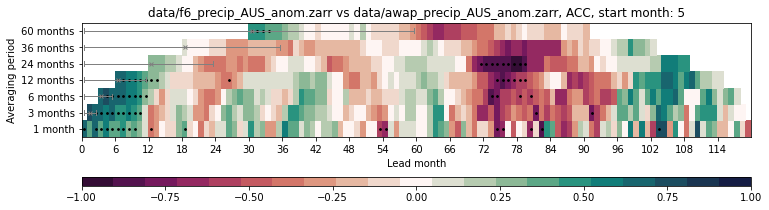

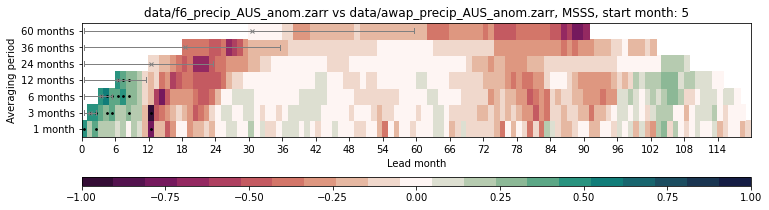

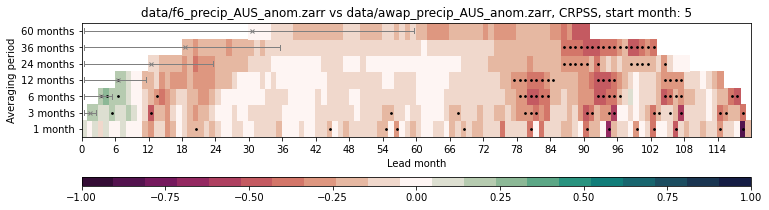

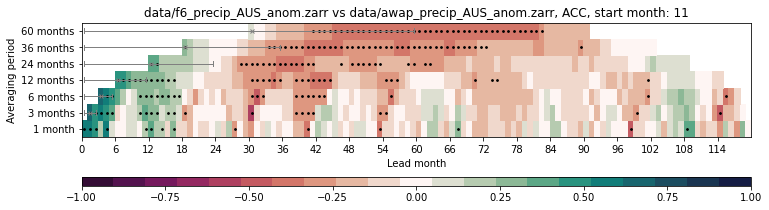

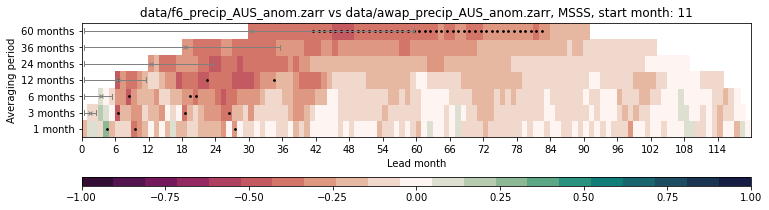

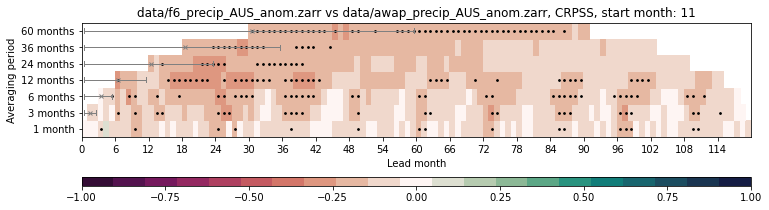

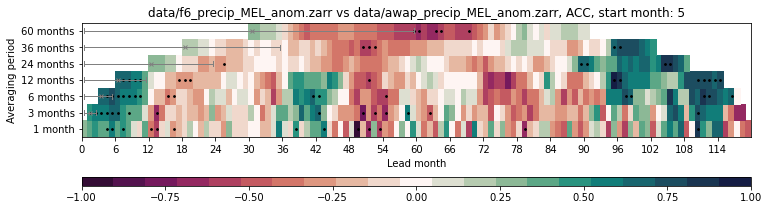

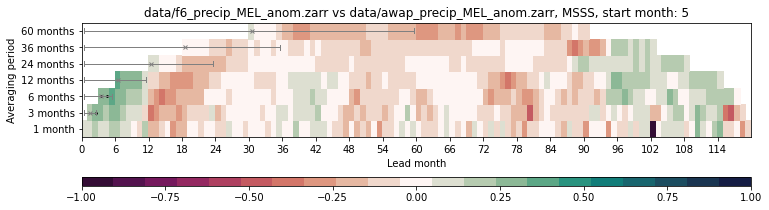

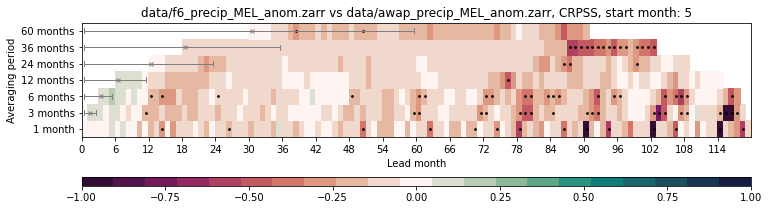

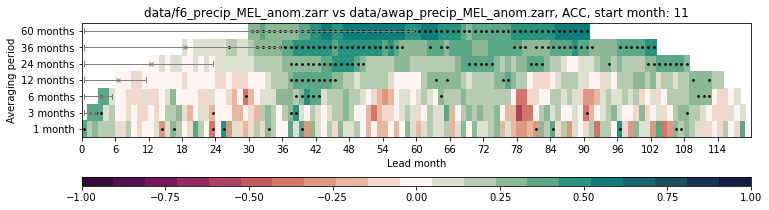

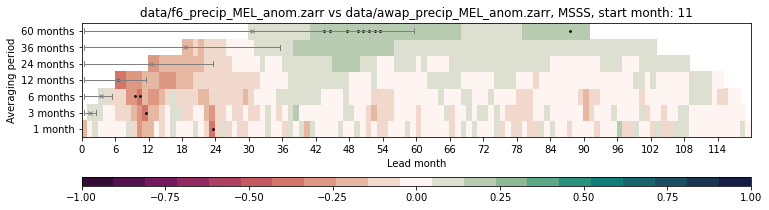

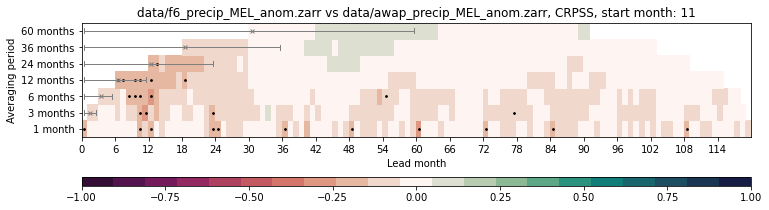

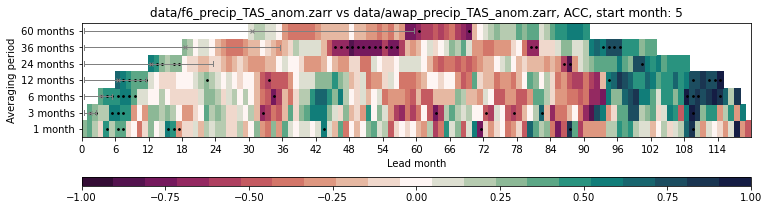

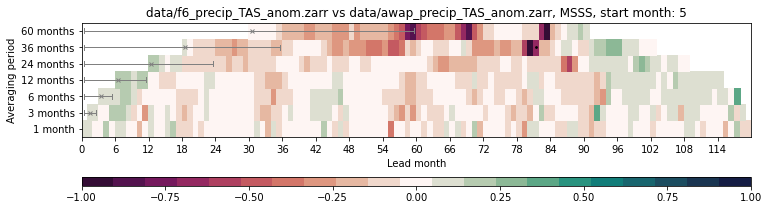

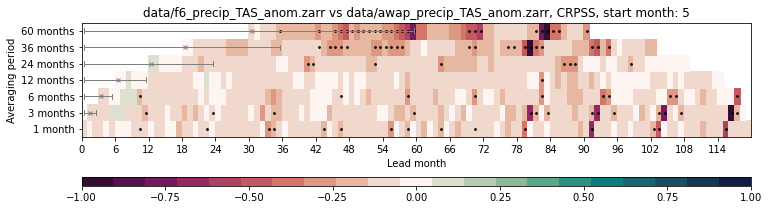

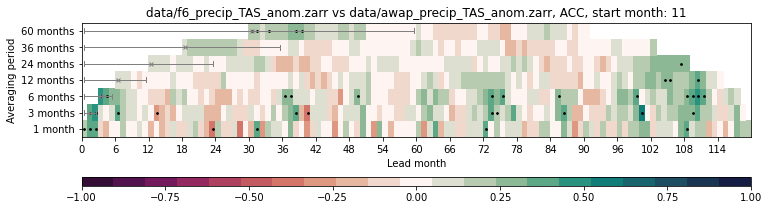

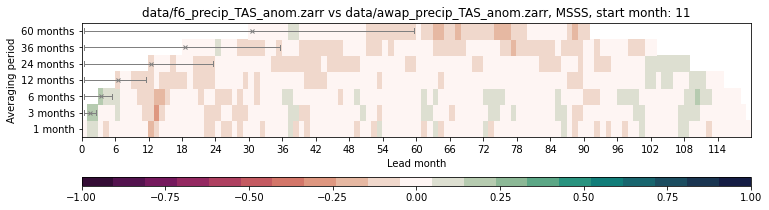

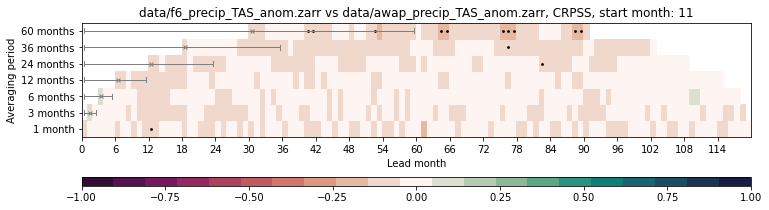

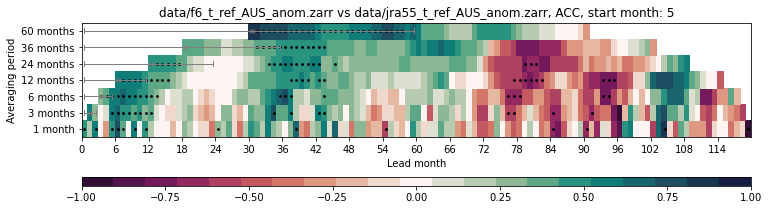

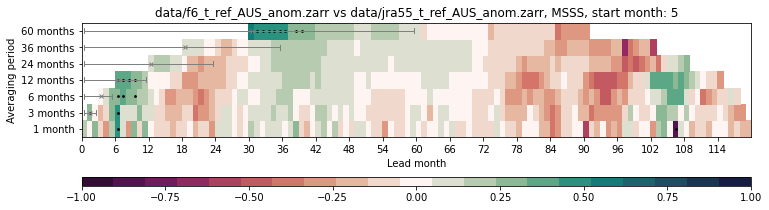

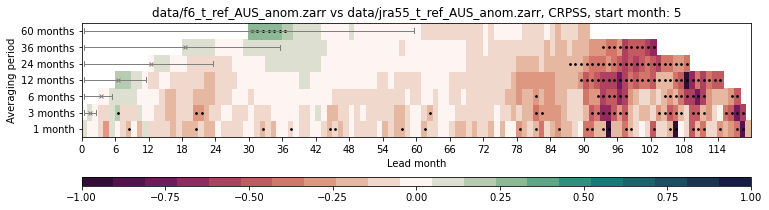

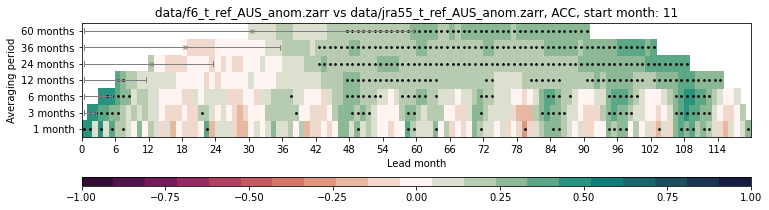

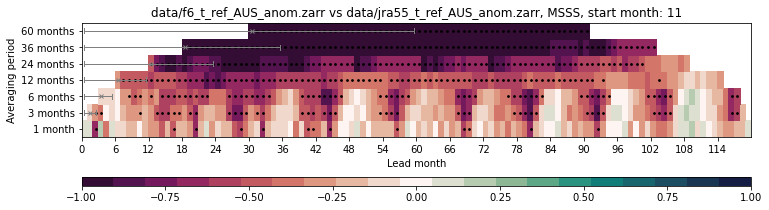

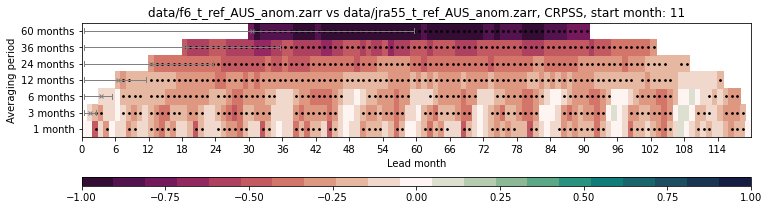

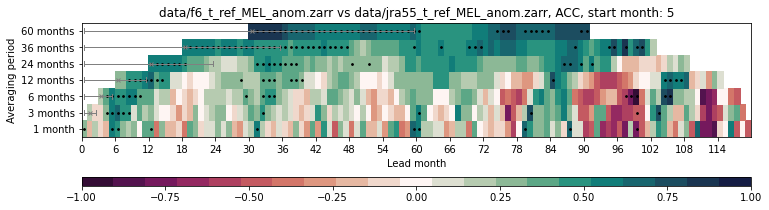

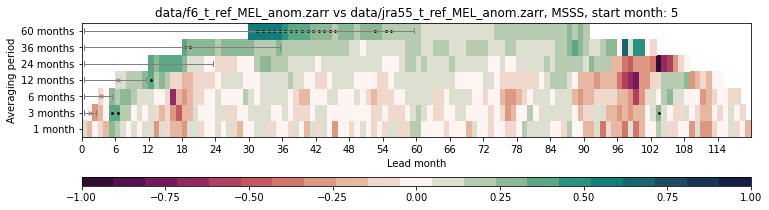

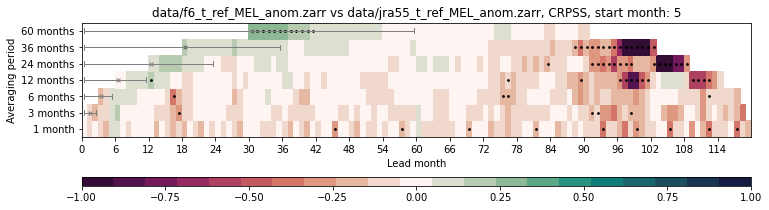

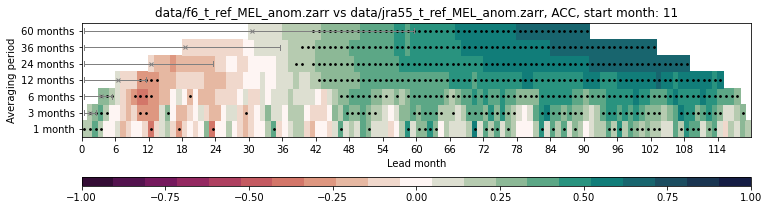

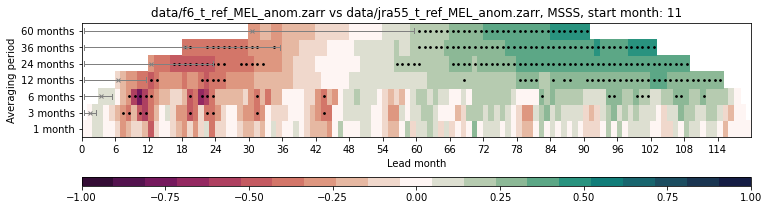

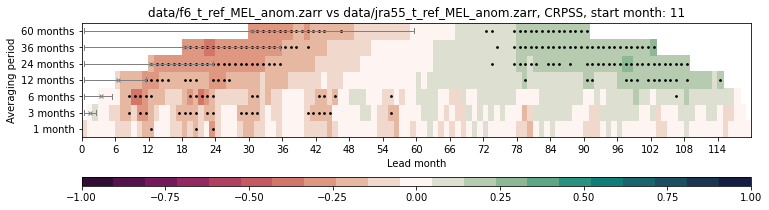

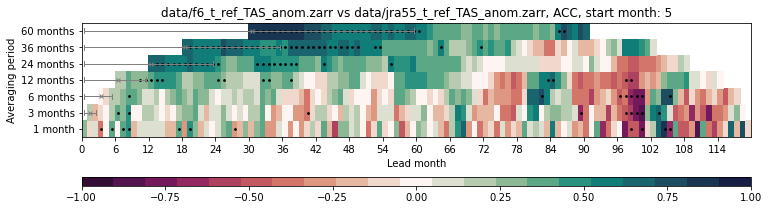

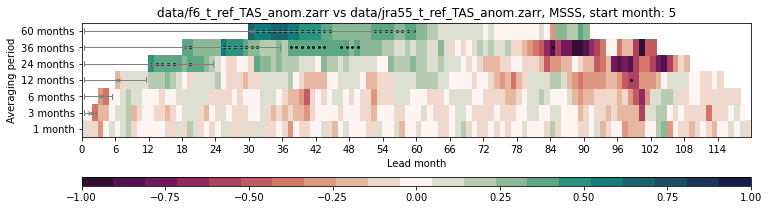

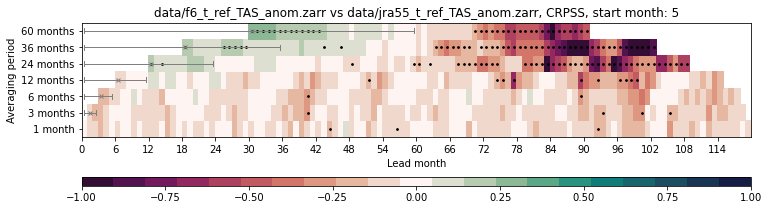

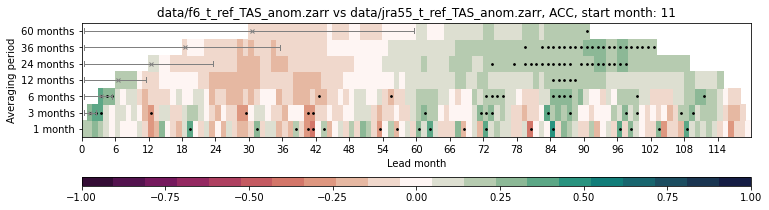

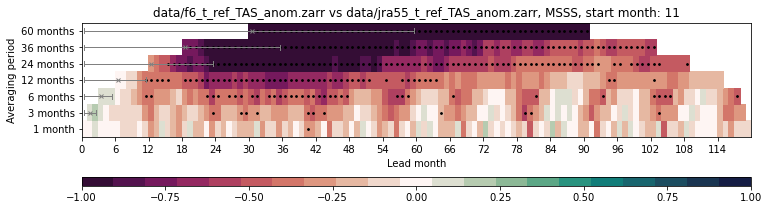

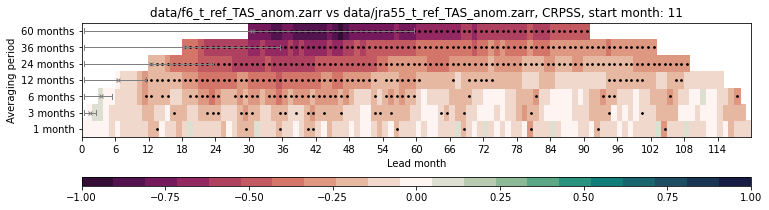

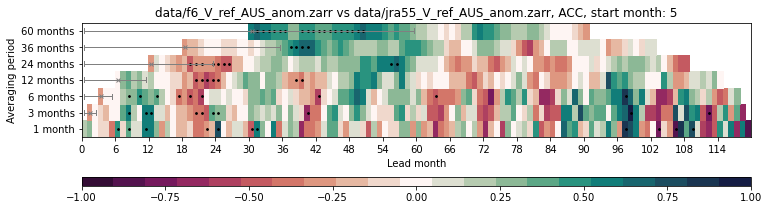

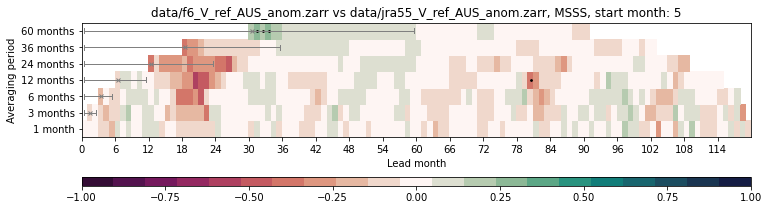

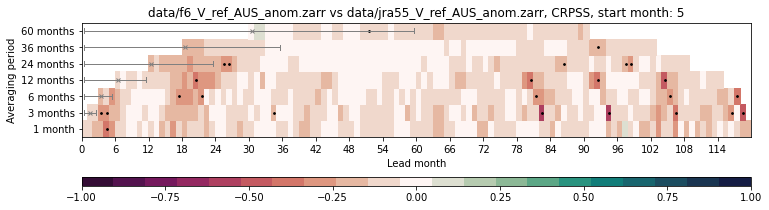

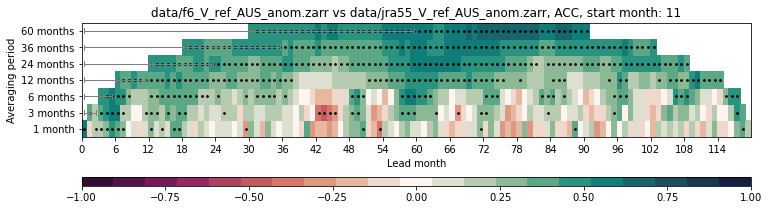

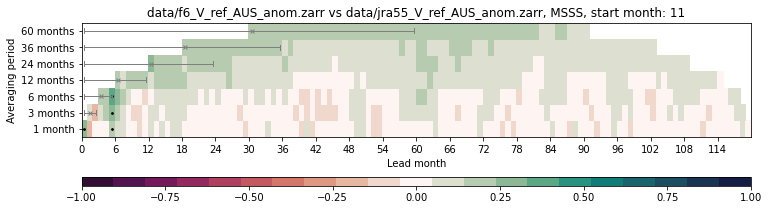

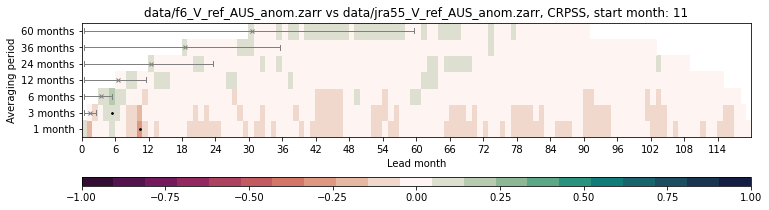

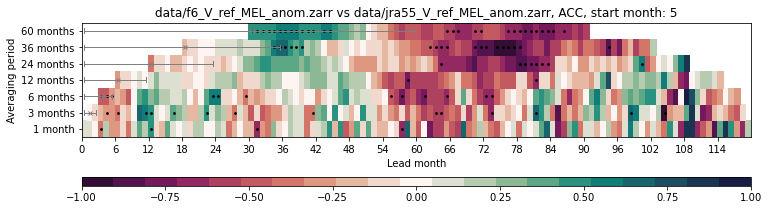

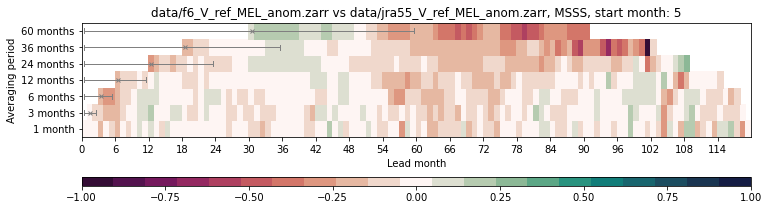

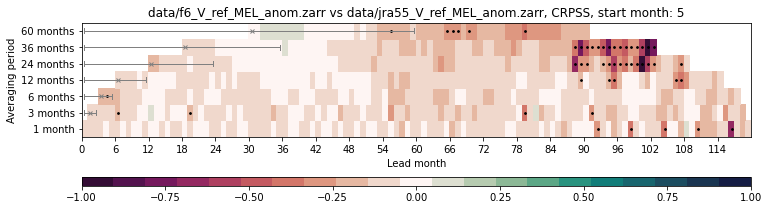

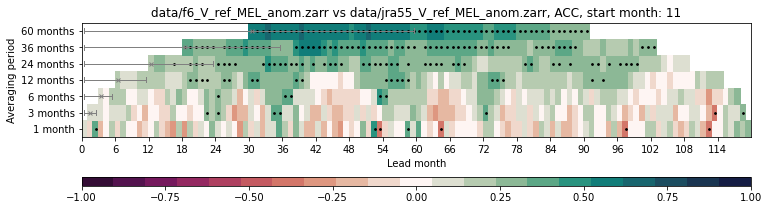

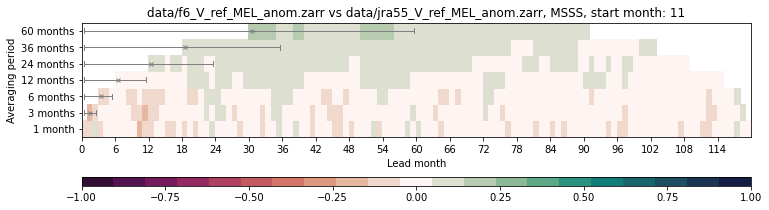

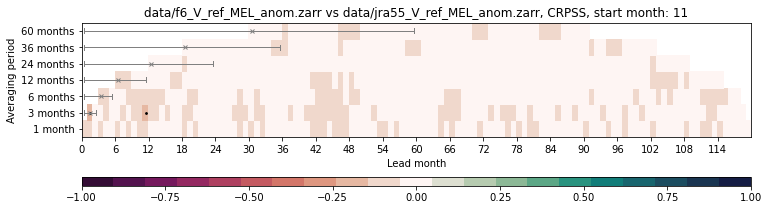

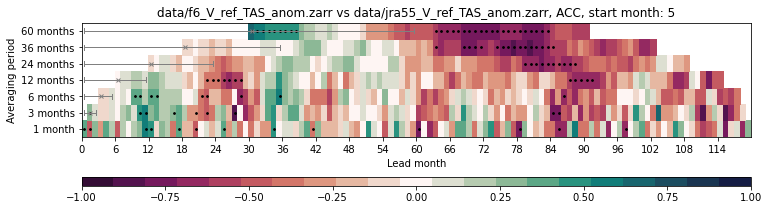

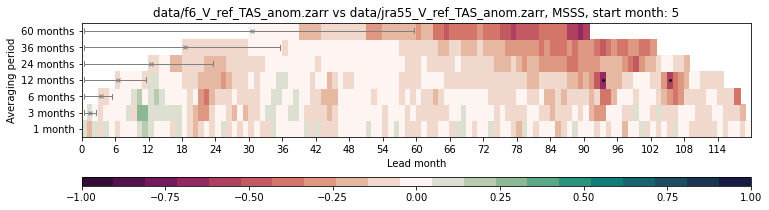

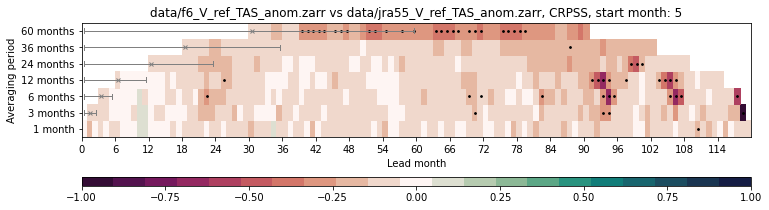

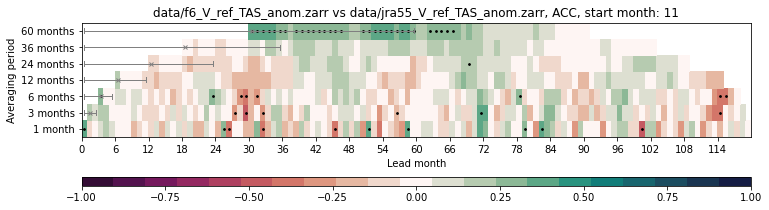

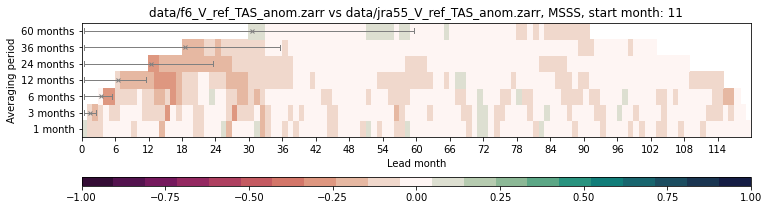

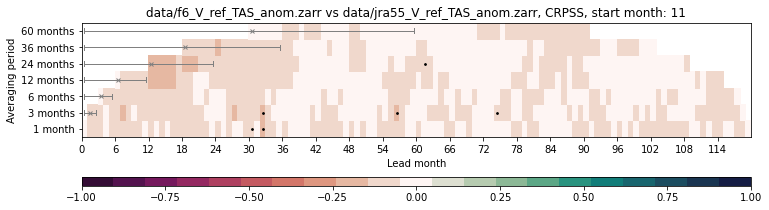

In [8]:
%%time
def _effify(s):
    "Evaluate as f string. This is dangerous with untrusted input"
    return eval(f'f"""{s}"""')

for params in PARAMS:
    for region in REGIONS:
        obsv_file = _effify(params['obsv_file'])
        fcst_file = _effify(params['fcst_file'])
        obsv = my.open_zarr(obsv_file).compute()
        fcst = my.open_zarr(fcst_file).compute()
        variable = list(fcst.data_vars)[0]
        
        start_months = np.unique(fcst.init_date.dt.month)
        for start_month in start_months:
            # Extract month and stack for jelly plots
            fcst_mon = my.get_rolling_leadtime_averages(
                fcst.where(fcst.init_date.dt.month == start_month, 
                           drop=True), 
                ROLLING_LEAD_AVERAGES)
            obsv_mon = my.get_rolling_leadtime_averages(
                obsv.where(obsv.init_date.dt.month == start_month, 
                           drop=True), 
                ROLLING_LEAD_AVERAGES)
            fcst_mon, obsv_mon = xr.align(fcst_mon, obsv_mon)
            
            # Reference forecasts
            clim_probs_mon = my.get_climatological_probabilities(obsv_mon, CLIM_PERIOD)
            clim_mean_mon = clim_probs_mon.mean('ensemble')
            
            n_init_dates = len(fcst_mon.init_date)
            n_ensembles = len(fcst_mon.ensemble)
            
            # Get skill metrics
            acc, acc_signif = _acc(fcst_mon, obsv_mon, TEST_PERIOD)
            my.jelly_plot(acc[variable], acc_signif[variable], 
                       stipple_type='o', stipple_color='k',
                       title=f'{fcst_file} vs {obsv_file}, ACC, start month: {start_month}', 
                       cmap=CMAP, vlims=(-1,1), figsize=(12,3))
            
            msss, msss_signif = _msss(fcst_mon, obsv_mon, clim_mean_mon, TEST_PERIOD)
            my.jelly_plot(msss[variable], msss_signif[variable], 
                       stipple_type='o', stipple_color='k',
                       title=f'{fcst_file} vs {obsv_file}, MSSS, start month: {start_month}', 
                       cmap=CMAP, vlims=(-1,1), figsize=(12,3))
            
            crpss, crpss_signif = _crpss(fcst_mon, obsv_mon, clim_probs_mon, TEST_PERIOD)
            my.jelly_plot(crpss[variable], crpss_signif[variable], 
                       stipple_type='o', stipple_color='k',
                       title=f'{fcst_file} vs {obsv_file}, CRPSS, start month: {start_month}', 
                       cmap=CMAP, vlims=(-1,1), figsize=(12,3))

# Impact of ensemble size
Focus on variables, regions, time scales where there is skill to begin with...

In [9]:
fcst = my.open_zarr('data/f6_V_ref_AUS_anom.zarr.zip').compute()
obsv = my.open_zarr('data/jra55_V_ref_AUS_anom.zarr.zip').compute()
variable = list(fcst.data_vars)[0]

start_month = 11
rolling_lead_averages = [12]
n_ensembles = list(range(5,96,20))+[96]

# Extract month and stack for jelly plots
fcst_mon = my.get_rolling_leadtime_averages(
    fcst.where(fcst.init_date.dt.month == start_month, 
               drop=True), 
    rolling_lead_averages).sel(time_scale=rolling_lead_averages[0])
obsv_mon = my.get_rolling_leadtime_averages(
    obsv.where(obsv.init_date.dt.month == start_month, 
               drop=True), 
    rolling_lead_averages).sel(time_scale=rolling_lead_averages[0])
fcst_mon, obsv_mon = xr.align(fcst_mon, obsv_mon)

# # Reference forecasts
clim_probs_mon = my.get_climatological_probabilities(obsv_mon, CLIM_PERIOD)
clim_mean_mon = clim_probs_mon.mean('ensemble')

# Get skill metrics
acc = []
msss = []
crpss = []
for n_ensemble in n_ensembles:
    acc.append(my.get_metric(
        fcst_mon.sel(ensemble=slice(0, n_ensemble)), 
        obsv_mon,
        metric=my.pearson_r_maybe_ensemble_mean, 
        metric_kwargs={'dim': 'init_date',
                       'skipna': True},
        period=TEST_PERIOD))

    msss.append(my.get_skill_score(
        fcst_mon.sel(ensemble=slice(0, n_ensemble)), 
        obsv_mon,
        clim_mean_mon,
        metric=my.mse_maybe_ensemble_mean,
        metric_kwargs={'dim': 'init_date',
                       'skipna': True},
        period=TEST_PERIOD))
    
    crpss.append(my.get_skill_score(
        fcst_mon.sel(ensemble=slice(0, n_ensemble)), 
        obsv_mon,
        clim_probs_mon,
        metric='crps_ensemble',
        metric_kwargs={'member_dim': 'ensemble',
                       'dim': 'init_date'},
        period=TEST_PERIOD))

acc = xr.concat(acc, dim='n_ensemble').assign_coords(
    {'n_ensemble': n_ensembles})
msss = xr.concat(msss, dim='n_ensemble').assign_coords(
    {'n_ensemble': n_ensembles})
crpss = xr.concat(crpss, dim='n_ensemble').assign_coords(
    {'n_ensemble': n_ensembles})

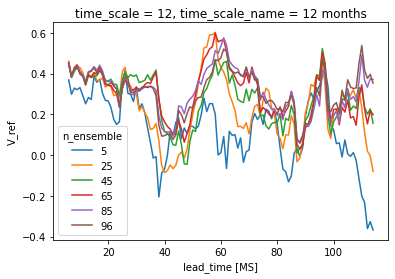

In [13]:
acc['V_ref'].plot.line(x='lead_time');

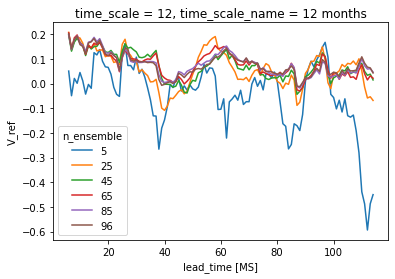

In [16]:
msss['V_ref'].plot.line(x='lead_time');

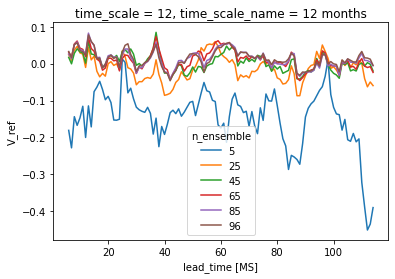

In [15]:
crpss['V_ref'].plot.line(x='lead_time');

# Play space

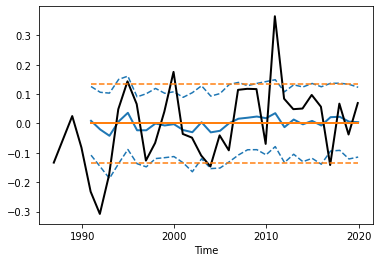

In [17]:
import matplotlib.pyplot as plt

fcst = my.open_zarr('data/f6_V_ref_AUS_anom.zarr.zip').compute()
obsv = my.open_zarr('data/jra55_V_ref_AUS_anom.zarr.zip').compute()
variable = list(fcst.data_vars)[0]

lead = 61
time_scale = 12 # month
start_month = 11

fcst_mon = my.get_rolling_leadtime_averages(
    fcst.where(fcst.init_date.dt.month == start_month, 
               drop=True), 
    [time_scale]).sel(time_scale=time_scale)
obsv_mon = my.get_rolling_leadtime_averages(
    obsv.where(obsv.init_date.dt.month == start_month, 
               drop=True), 
    [time_scale]).sel(time_scale=time_scale)
fcst_mon, obsv_mon = xr.align(fcst_mon, obsv_mon)
clim_probs_mon = my.get_climatological_probabilities(obsv_mon, CLIM_PERIOD)
clim_mean_mon = clim_probs_mon.mean('ensemble')

std = my.mask_time_period(
    fcst_mon.std('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
mean = my.mask_time_period(
    fcst_mon.mean('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
plt.plot(mean.time, (mean - std), color='C0', linestyle='--')
plt.plot(mean.time, (mean + std), color='C0', linestyle='--')
plt.plot(mean.time, mean, color='C0', linewidth=2)
a = mean

ref = obsv_mon[variable].isel(lead_time=lead)
plt.plot(ref.time, ref, color='k', linewidth=2)
b = ref

std = my.mask_time_period(
    clim_probs_mon.std('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
mean = my.mask_time_period(
    clim_probs_mon.mean('ensemble')[variable].isel(lead_time=lead),
    TEST_PERIOD)
plt.plot(mean.time, (mean - std).where(ref.notnull()), color='C1', linestyle='--')
plt.plot(mean.time, (mean + std).where(ref.notnull()), color='C1', linestyle='--')
plt.plot(mean.time, mean.where(ref.notnull()), color='C1', linewidth=2)

plt.xlabel('Time');